# import modules

In [1]:
import sys

sys.path.insert(0, "../")

from modules.Classes_ver1 import *
from modules.default_params_ver1 import *
from modules.functions_ver1_draft import *

# # after making changes to scripts, reload them
# import importlib

# import scripts.Classes_ver1
# importlib.reload(scripts.Classes_ver1)
# from scripts.Classes_ver1 import *

# import scripts.default_params_ver1
# importlib.reload(scripts.default_params_ver1)
# from scripts.default_params_ver1 import *

# import scripts.functions_ver1
# importlib.reload(scripts.functions_ver1)
# from scripts.functions_ver1 import *

# define plotting functions

In [2]:
# plot contour of mismatch between RP & L as a function of omega_tilde and theta_tilde

def mismatch_contour_P(cmd, l_params, rp_params, np_params, lens_Class=LensingGeo, prec_Class=Precessing):
    n_pts = 60
    omega_tilde_arr = np.linspace(0, 3, n_pts)
    theta_tilde_arr = np.linspace(0, 8, n_pts)
    X, Y = np.meshgrid(omega_tilde_arr, theta_tilde_arr)
    Z = np.zeros_like(X)
    g_min_matrix = np.zeros_like(X)

    for r in range(n_pts):
        for c in range(n_pts):
            rp_params["omega_tilde"] = X[r, c]
            rp_params["theta_tilde"] = Y[r, c]
            
            optimized_mismatch = optimize_mismatch_gammaP(
                cmd, l_params, rp_params, np_params, lens_Class, prec_Class
            )
            Z[r, c] = optimized_mismatch["ep_min"]
            g_min_matrix[r, c] = optimized_mismatch["g_min"]

    # print mismatch at the bottom left corner
    print("mismatch at bottom left corner = {:.3g}".format(Z[0, 0]))

    # print coordinates where mismatch is min
    min_idx = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
    print("min mismatch = {:.3g}".format(Z[min_idx]))
    print("min omega_tilde = {:.3g}".format(X[min_idx]))
    print("min theta_tilde = {:.3g}".format(Y[min_idx]))
    print("min gamma_P = {:.3g}".format(g_min_matrix[min_idx]))
    
    # print coordinates where mismatch is max
    max_idx = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
    print("max mismatch = {:.3g}".format(Z[max_idx]))
    print("max omega_tilde = {:.3g}".format(X[max_idx]))
    print("max theta_tilde = {:.3g}".format(Y[max_idx]))

    plt.contourf(X, Y, Z, levels=60, cmap="jet")
    plt.xlabel(r"$\tilde{\Omega}$")
    plt.ylabel(r"$\tilde{\theta}$")
    
    if cmd in ["L & RP", "RP & L"]:
        plt.colorbar(label=r"$\epsilon(\~h_{\rm P}, \~h_{\rm L})$", cmap="jet", norm=colors.Normalize(vmin=0, vmax=1))
    elif cmd in ["RP & NP", "NP & RP"]:
        plt.colorbar(label=r"$\epsilon(\~h_{\rm RP}, \~h_{\rm NP})$", cmap="jet", norm=colors.Normalize(vmin=0, vmax=1))

    plt.title(
        r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}".format(
            rp_params["theta_S"],
            rp_params["phi_S"],
            rp_params["theta_J"],
            rp_params["phi_J"],
        )
    )

In [3]:
# make a function to plot mismatch between fixed RP & L as a function of theta_J and phi_J

def mismatch_contour_J_mcz(cmd, l_params, rp_params, np_params, lens_Class=LensingGeo, prec_Class=Precessing):
    n_pts = 30
    phi_J_arr = np.linspace(0, 2*np.pi, n_pts)
    theta_J_arr = np.linspace(0, np.pi, n_pts)
    X, Y = np.meshgrid(phi_J_arr, theta_J_arr)
    Z = np.zeros_like(X)
    g_min_matrix = np.zeros_like(X)
    mcz_min_matrix = np.zeros_like(X)

    for r in range(n_pts):
        for c in range(n_pts):
            l_params["phi_J"] = rp_params["phi_J"] = np_params["phi_J"] = X[r, c]
            l_params["theta_J"] = rp_params["theta_J"] = np_params["theta_J"] = Y[r, c]
            
            results_dict = optimize_mismatch_gammaP_mcz(
                cmd, l_params, rp_params, np_params, lens_Class, prec_Class
            )

            np_params["mcz"] = results_dict["ep_min_mcz"]
            ep_NP_L = mismatch_epsilon("NP & L", l_params, rp_params, np_params, lens_Class, prec_Class)
            results_dict["ep_NP_L"] = ep_NP_L
            ep_ratio = results_dict["ep_min"] / ep_NP_L
            results_dict["ep_ratio"] = ep_ratio

            Z[r, c] = results_dict["ep_ratio"]
            g_min_matrix[r, c] = results_dict["ep_min_gamma"]
            mcz_min_matrix[r, c] = results_dict["ep_min_mcz"]

    # print coordinates where mismatch is min
    min_idx = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
    print("min mismatch ratio = {:.3g}".format(Z[min_idx]))
    print("min mismatch phi_J = {:.3g}".format(X[min_idx]))
    print("min mismatch theta_J = {:.3g}".format(Y[min_idx]))
    print("min mismatch gamma_P = {:.3g}".format(g_min_matrix[min_idx]))
    print("min mismatch mcz = {:.3g}".format(mcz_min_matrix[min_idx] / solar_mass))

    plt.contourf(X, np.cos(Y), Z, levels=30, cmap="jet")
    plt.xlabel(r"$\phi_J$")
    plt.xticks(np.arange(0, 2*np.pi + np.pi/4, np.pi/4), [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$', r'$2\pi$'])
    plt.ylabel(r'$\cos \theta_J$')
    
    if cmd in ["L & RP", "RP & L"]:
        plt.colorbar(label=r"$\frac{\epsilon(\~h_{\rm RP}, \~h_{\rm L})} {\epsilon(\~h_{\rm NP}, \~h_{\rm L})}$", cmap="jet", norm=colors.Normalize(vmin=0, vmax=1))
    elif cmd in ["RP & NP", "NP & RP"]:
        plt.colorbar(label=r"$\epsilon(\~h_{\rm RP}, \~h_{\rm NP})$", cmap="jet", norm=colors.Normalize(vmin=0, vmax=1))
    
    plt.title(
        r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, {} = {:.3g}, {} = {:.3g}".format(
            rp_params["theta_S"],
            rp_params["phi_S"],
            r"$\~{\theta}$",
            rp_params["theta_tilde"],
            r"$\~{\Omega}$",
            rp_params["omega_tilde"],
        )
    )

# mismatch between RP & L with L fixed

## face-on

In [ ]:
lens_params, RP_params, NP_params = set_to_location(loc_params['sys1']['faceon'], lens_params_0, RP_params_0, NP_params_0)

# set mcz for lensed, RP, NP
mcz = 40
lens_params['mcz'] = RP_params['mcz'] = NP_params['mcz'] = mcz * solar_mass

mismatch_contour_P( "RP & L", lens_params, RP_params, NP_params)

## edge-on

In [ ]:
lens_params, RP_params, NP_params = set_to_location(loc_params['sys1']['edgeon'], lens_params_0, RP_params_0, NP_params_0)

# set mcz for lensed, RP, NP
mcz = 40
lens_params['mcz'] = RP_params['mcz'] = NP_params['mcz'] = mcz * solar_mass

mismatch_contour_P( "RP & L", lens_params, RP_params, NP_params)

## random

In [ ]:
lens_params, RP_params, NP_params = set_to_location(loc_params['sys1']['random'], lens_params_0, RP_params_0, NP_params_0)

# set mcz for lensed, RP, NP
mcz = 40
lens_params['mcz'] = RP_params['mcz'] = NP_params['mcz'] = mcz * solar_mass

mismatch_contour_P( "RP & L", lens_params, RP_params, NP_params)

# mismatch between fixed RP & L as a function of $\theta_J$ & $\phi_J$

In [ ]:
lens_params, RP_params, NP_params = set_to_location(loc_params['sys2']['random'], lens_params_0, RP_params_0, NP_params_0)
phi_S, theta_S = lens_params['phi_S'], lens_params['theta_S']

# set mcz for lensed, RP, NP
mcz = 40
lens_params['mcz'] = RP_params['mcz'] = NP_params['mcz'] = mcz * solar_mass

# set RP to 1% in theta_omega_pairs
RP_params['omega_tilde'] = omega_theta_tilde_pairs['05%']['omega_tilde']
RP_params['theta_tilde'] = omega_theta_tilde_pairs['05%']['theta_tilde']

mismatch_contour_J_mcz("RP & L", lens_params, RP_params, NP_params)
plot_special_coords("S", phi_S, theta_S)

/Users/fairytien/Google Drive (fairynguyen33@gmail.com)/TEXAS Bridge Program 2023-2024/code/Tien's/scripts/Classes_ver1.py:386: RuntimeWarning: divide by zero encountered in divide
  tan_psi = num_psi / den_psi
/Users/fairytien/Google Drive (fairynguyen33@gmail.com)/TEXAS Bridge Program 2023-2024/code/Tien's/scripts/Classes_ver1.py:389: RuntimeWarning: divide by zero encountered in divide
  tan_psi = num_psi / den_psi
/opt/homebrew/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


min mismatch ratio = 0.012
min mismatch phi_J = 1.95
min mismatch theta_J = 1.08
min mismatch gamma_P = 0.889
min mismatch mcz = 39
order of arguments: phi_S, theta_S, phi_J, theta_J


/Users/fairytien/Google Drive (fairynguyen33@gmail.com)/TEXAS Bridge Program 2023-2024/code/Tien's/scripts/functions_ver2.py:313: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(


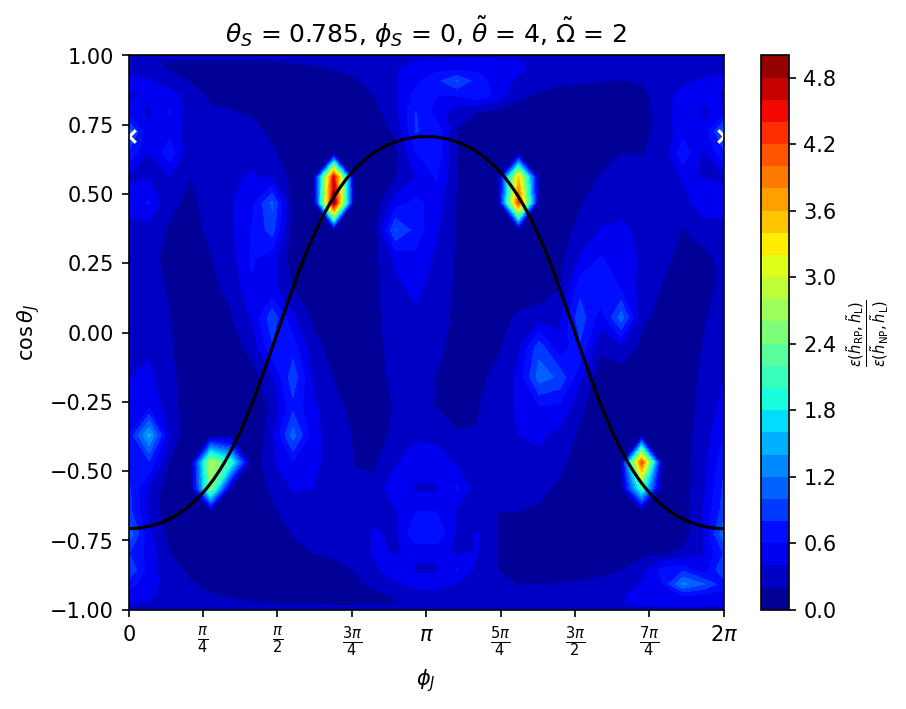

In [6]:
lens_params, RP_params, NP_params = set_to_location(loc_params['sys2']['random'], lens_params_0, RP_params_0, NP_params_0)
phi_S, theta_S = lens_params['phi_S'], lens_params['theta_S']

# set mcz for lensed, RP, NP
mcz = 40
lens_params['mcz'] = mcz * solar_mass

# set RP to 1% in theta_omega_pairs
RP_params['omega_tilde'] = omega_theta_tilde_pairs['50%']['omega_tilde']
RP_params['theta_tilde'] = omega_theta_tilde_pairs['50%']['theta_tilde']

mismatch_contour_J_mcz("RP & L", lens_params, RP_params, NP_params)
plot_special_coords("S", phi_S, theta_S)

In [ ]:
lens_params, RP_params, NP_params = set_to_location(loc_params['sys2']['random'], lens_params_0, RP_params_0, NP_params_0)
phi_S, theta_S = lens_params['phi_S'], lens_params['theta_S']

# set mcz for lensed, RP, NP
mcz = 40
lens_params['mcz'] = RP_params['mcz'] = NP_params['mcz'] = mcz * solar_mass

# set RP to 1% in theta_omega_pairs
RP_params['omega_tilde'] = omega_theta_tilde_pairs['95%']['omega_tilde']
RP_params['theta_tilde'] = omega_theta_tilde_pairs['95%']['theta_tilde']

mismatch_contour_J_mcz("RP & L", lens_params, RP_params, NP_params)
plot_special_coords("S", phi_S, theta_S)